In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import MultinomialNB

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.gaussian_process import GaussianProcessClassifier
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, confusion_matrix,classification_report

import glob 

import nltk
from nltk.corpus import stopwords
import nltk as nlp
import string
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Using TensorFlow backend.


In [2]:
# Long form news [fake/real]
fake = pd.read_csv('./news/Fake.csv')
real = pd.read_csv('./news/True.csv')
fake['target'] = 'fake'
real['target'] = 'true'

In [3]:
fake.head()

,title,text,subject,date,target
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


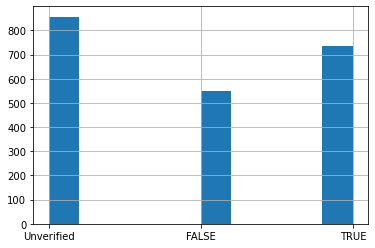

In [4]:
# Rumour specific 
emergent = pd.read_csv('./news/rumours/emergent.csv')
emergent["claim"] = emergent["claim"].str[6]
emergent["claim_label"].hist()

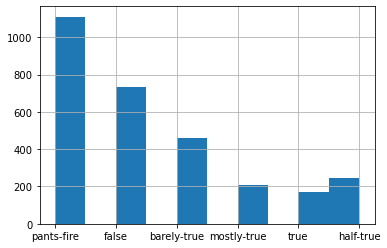

In [5]:
politifact = pd.read_csv('./news/rumours/politifact.csv')
politifact["claim_label"].hist()

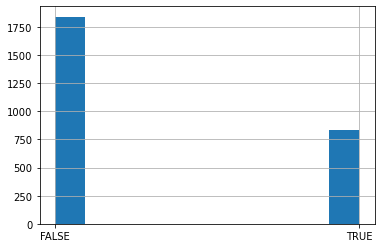

In [6]:
politifact["claim_label"].replace(to_replace = ['pants-fire', 'false'], value = 'FALSE', inplace = True)
politifact["claim_label"].replace(to_replace = ['mostly-true', 'barely-true', 'true'], value = 'TRUE', inplace = True)
politifact = politifact[~politifact["claim_label"].str.contains('half-true')] # Remove half-truths
politifact["claim_label"].hist()

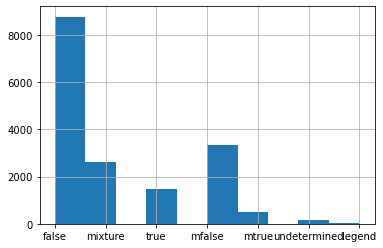

In [7]:
snopes = pd.read_csv('./news/rumours/snopes.csv')
snopes["claim_label"].hist()

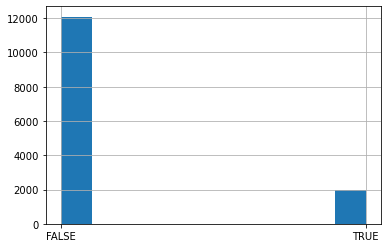

In [8]:
snopes["claim_label"].replace(to_replace = ['mfalse', 'false'], value = 'FALSE', inplace = True)
snopes["claim_label"].replace(to_replace = ['true', 'mtrue'], value = 'TRUE', inplace = True)
snopes = snopes[snopes["claim_label"].str.contains('TRUE|FALSE', regex = True)] # Take only truth and false
snopes["claim_label"].hist()

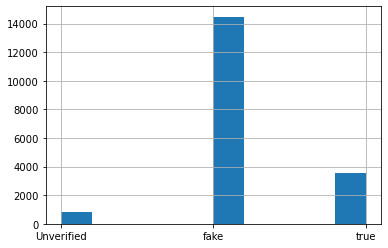

In [9]:
full_rumour_sites = pd.concat([emergent, politifact, snopes]).filter(["claim", "claim_description", "claim_label"])
# Convert to fake / real
full_rumour_sites["claim_label"].replace(to_replace = ['TRUE'], value = 'true', inplace = True)
full_rumour_sites["claim_label"].replace(to_replace = ['FALSE'], value = 'fake', inplace = True)
full_rumour_sites["claim_label"].hist()
# Combine columns
full_rumour_sites["text"] = (full_rumour_sites['claim'].fillna('') + '_' + full_rumour_sites['claim_description'].fillna('')).str.strip('_')
full_rumour_sites = full_rumour_sites[["text", "claim_label"]]
full_rumour_sites.rename(columns = {'claim_label': 'target'}, inplace = True)

,text,target
16860,Photographs show a border fence between the co...,fake
16861,Photographs show a border fence between the co...,fake
16862,Photographs show a border fence between the co...,fake
16863,Photographs show a border fence between the co...,fake
16864,Photographs show a border fence between the co...,fake


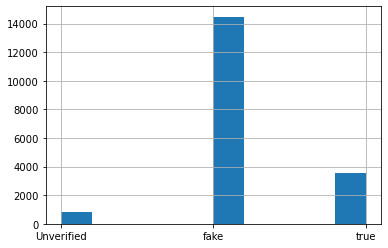

In [10]:
full_rumour_sites.dropna(inplace = True)
full_rumour_sites['target'].hist()
full_rumour_sites.tail()

In [11]:
# Add in the newly emerged rumour dataset on twitter: https://zenodo.org/record/2563864
path = r'./news/rumours/newly_emerged'
all_files = glob.glob(path + "/*.xlsx")
li = []

for file in all_files:
    df = pd.read_excel(file, index_col=None, header=0)
    li.append(df)

newly_emerged = pd.concat(li, axis=0, ignore_index=True)

,ID,Description,#Tweets,Date_time_creation_account,Language,#Followers,#Friends,Date&Time,#Favorite,#Retweet,Another Tweet Inside,Source,Tweet ID,Retweet ID,Quote ID,Reply ID,Frequency of tweet occurrences,State of Tweet
0,2752994783,// Kirby// they/them // 20 // ENG: ok // FR: ok,2822,"2014 , Aug , 28 , 01:49:22",en,34,68,"['2017', 'Dec', '15', '15:42:41']",0,250,0,iPhone,941695012122910720,940977667104477185,Not a quote,None,213.0,r
1,21571977,Follow us for the latest headlines across the ...,3085,"2009 , Feb , 22 , 15:32:48",en,21083,31,"['2017', 'Dec', '15', '15:37:51']",0,0,0,iPhone,941693798056280064,Not a Retweet,Not a quote,None,1,n
2,3382041618,Growing minds... Changing lives.,46,"2015 , Aug , 29 , 13:45:01",en,82,68,"['2017', 'Dec', '15', '15:37:37']",0,0,0,iPhone,941693735678758912,Not a Retweet,Not a quote,None,1,n
3,348478568,NaN,2007,"2011 , Aug , 04 , 14:08:52",en,26,270,"['2017', 'Dec', '15', '15:37:16']",0,0,0,Client,941693648634372097,Not a Retweet,Not a quote,None,1,n
4,724097168152367104,One does not simply un-FeelTheBern! 🔥,13050,"2016 , Apr , 24 , 04:46:32",en,166,287,"['2017', 'Dec', '15', '15:35:34']",0,151,0,iPhone,941693221704536064,941044904742006786,Not a quote,None,140.0,a


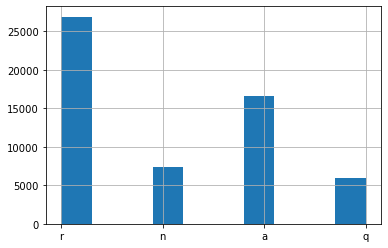

In [12]:
newly_emerged.head()
newly_emerged = newly_emerged[["Description", "State of Tweet"]]
newly_emerged["State of Tweet"].hist()

In [13]:
newly_emerged["State of Tweet"].replace(to_replace = ['r'], value = 'fake', inplace = True)
newly_emerged["State of Tweet"].replace(to_replace = ['n'], value = 'true', inplace = True)
newly_emerged["State of Tweet"].replace(to_replace = ['q'], value = 'Unverified', inplace = True)

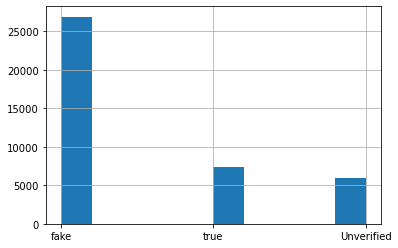

In [14]:
newly_emerged = newly_emerged[newly_emerged["State of Tweet"].str.contains('true|fake|Unverified', regex = True)]
newly_emerged["State of Tweet"].hist()

In [15]:
newly_emerged.rename(columns = {'Description': 'text', 'State of Tweet': 'target'}, inplace = True)
newly_emerged.head()

,text,target
0,// Kirby// they/them // 20 // ENG: ok // FR: ok,fake
1,Follow us for the latest headlines across the ...,true
2,Growing minds... Changing lives.,true
3,NaN,true
5,NaN,true


In [16]:
newly_emerged.dropna(inplace = True)

In [17]:
newly_emerged.head()

,text,target
0,// Kirby// they/them // 20 // ENG: ok // FR: ok,fake
1,Follow us for the latest headlines across the ...,true
2,Growing minds... Changing lives.,true
7,Human. Woman. Mother. Wife. Reader. Learner. T...,true
8,My family call me Winyan Ohmanisa Waste La Ke....,fake


In [18]:
path = r'./news/rumours/scraped'
all_files = glob.glob(path + "/*.csv")
li = []

for file in all_files:
    df = pd.read_csv(file, dtype = {'text': str, 'target' : str})
    li.append(df)

scraped_fb_twitter = pd.concat(li, axis=0, ignore_index=True)
scraped_fb_twitter.drop_duplicates(inplace = True)
scraped_fb_twitter.head()

,Unnamed: 0,text,target
0,0,UOW has improved our place in the QS World Uni...,true
1,1,"""We had to work hard to get here and be the li...",true
2,2,“In a lifetime we come across through many peo...,true
3,3,"It’s Sunday, her dad and two younger sisters s...",true
4,4,This article by UOW's Professor Anthony Dosset...,true


0       true
1       true
2       true
3       true
4       true
        ... 
4393    true
4394    true
4395    true
4396    true
4397    true
Name: target, Length: 3700, dtype: object

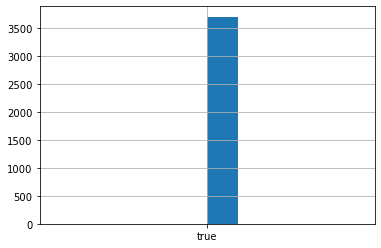

In [19]:
scraped_fb_twitter = scraped_fb_twitter[["text", "target"]]
scraped_fb_twitter['target'].apply(lambda row: row.lower())
scraped_fb_twitter['target'].hist()

,text,target
100593,Taiwanese Director Doze Niu Appeals Against Gu...,true
100594,South Korean cafe hires robot barista to help ...,true
100595,Vegan launches healthy version of his childhoo...,true
100596,What’s the risk of catching coronavirus from a...,true
100597,"Cooked up for climate, UAE's high-tech food pl...",true


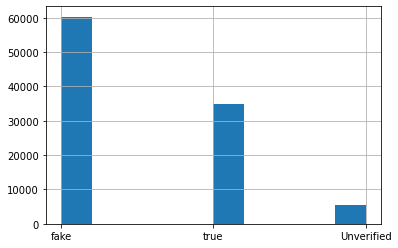

In [20]:
news = pd.concat([fake, real, full_rumour_sites, newly_emerged, scraped_fb_twitter]).reset_index(drop = True)
news = news[['text', 'target']]
news.tail()
news['target'].hist()

In [21]:
news = news[~news['target'].str.contains("Unverified")] #Remove unverified
news.head()

,text,target
0,Donald Trump just couldn t wish all Americans ...,fake
1,House Intelligence Committee Chairman Devin Nu...,fake
2,"On Friday, it was revealed that former Milwauk...",fake
3,"On Christmas day, Donald Trump announced that ...",fake
4,Pope Francis used his annual Christmas Day mes...,fake


In [22]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\resuu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

68494                                                thing
89004    much clout bootleg club penguin account billy ...
36287    co bazar reuters dawn hues pink purple reveal ...
33441    new york reuters jpmorgan chase co lambasted d...
38280    reuters zimbabwe military action takeover gove...
Name: text, dtype: object

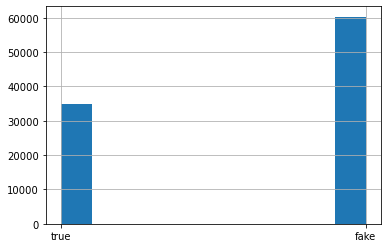

In [23]:
news = shuffle(news)
news["text"] = news["text"].apply(lambda row: clean_text(str(row)))
news['text'].head()
news["target"].hist()

In [24]:
# Need to oversample since the classes are imbalanced.
x_train,x_test,y_train,y_test = train_test_split(news['text'], news.target, test_size=0.2, random_state= 420)

#Add back training dataset
X = pd.concat([x_train, y_train], axis = 1)

#Separate minority / majority classes
_true = X[X.target == 'true']
_fake = X[X.target == 'fake']
# _Unverified = X[X.target == 'Unverified']

from sklearn.utils import resample

# _true_sampled = resample(_true, 
#                          replace = True,
#                          n_samples = len(_Unverified),
#                          random_state = 2020)

_fake_sampled = resample(_fake, 
                         replace = True,
#                          n_samples = len(_Unverified),
                         n_samples = len(_true),
                         random_state = 2020)
#Add together again
# X = pd.concat([_fake_sampled, _true_sampled, _Unverified])
X = pd.concat([_fake_sampled, _true])
X.target.value_counts()


true    27848
fake    27848
Name: target, dtype: int64

In [25]:
# Add back to the original naming conventions so that we can train the model with the oversampled data
x_train = X.text
y_train = X.target
# x_train.hist()

In [26]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression(dual=False,  max_iter = 1000,  class_weight = 'balanced'))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
# prediction = model.predict([clean_text("UOW has improved our place in the QS World University Rankings, climbing sixteen places to 196th in the world and 10th in Australia. In 2013 the University set a strategic goal to be ranked in the Top 200 universities in the world. This new ranking puts UOW into that coveted position of Top 200 universities globally. UOW competed with over 1600 institutions worldwide, including 36 Australian universities, and has jumped 87 places in six years due to our globally recognised research activities. Thank you to our UOW research community for your dedication to delivering impact for a better world.")])
# prediction = model.predict(["fo news uses photo married couple promoting tr"])
# prediction

In [27]:
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))


accuracy: 92.59%
[[11295   663]
 [  749  6341]]
              precision    recall  f1-score   support

        fake       0.94      0.94      0.94     11958
        true       0.91      0.89      0.90      7090

    accuracy                           0.93     19048
   macro avg       0.92      0.92      0.92     19048
weighted avg       0.93      0.93      0.93     19048



In [28]:
# x_train,x_test,y_train,y_test = train_test_split(news['text'], news.target, test_size=0.3, random_state=2020)

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)

In [248]:
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))
import joblib
joblib.dump(model, './log_model.joblib')

accuracy: 93.35%
[[11351   745]
 [  521  6431]]
              precision    recall  f1-score   support

        fake       0.96      0.94      0.95     12096
        true       0.90      0.93      0.91      6952

    accuracy                           0.93     19048
   macro avg       0.93      0.93      0.93     19048
weighted avg       0.93      0.93      0.93     19048



In [249]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', MultinomialNB())])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)

In [250]:
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))

accuracy: 85.92%
[[10325  1771]
 [  911  6041]]
              precision    recall  f1-score   support

        fake       0.92      0.85      0.89     12096
        true       0.77      0.87      0.82      6952

    accuracy                           0.86     19048
   macro avg       0.85      0.86      0.85     19048
weighted avg       0.87      0.86      0.86     19048



In [251]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 10, 
                                           splitter='best', 
                                           random_state=2020))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)

In [252]:
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))


accuracy: 88.2%
[[12015    81]
 [ 2167  4785]]
              precision    recall  f1-score   support

        fake       0.85      0.99      0.91     12096
        true       0.98      0.69      0.81      6952

    accuracy                           0.88     19048
   macro avg       0.92      0.84      0.86     19048
weighted avg       0.90      0.88      0.88     19048



In [253]:
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', KNeighborsClassifier(n_neighbors = 10,weights = 'distance',algorithm = 'brute'))])

model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)

array(['fake', 'fake', 'fake', ..., 'fake', 'fake', 'fake'], dtype=object)

In [254]:
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
print(confusion_matrix(y_test, prediction))
print(classification_report(y_test, prediction))


accuracy: 74.48%
[[11771   325]
 [ 4536  2416]]
              precision    recall  f1-score   support

        fake       0.72      0.97      0.83     12096
        true       0.88      0.35      0.50      6952

    accuracy                           0.74     19048
   macro avg       0.80      0.66      0.66     19048
weighted avg       0.78      0.74      0.71     19048



In [271]:
## LSTM
X = news.text
Y = news.target
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

array([[1],
       [0],
       [1],
       ...,
       [1],
       [0],
       [0]])

In [256]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)
max_words = 500
max_len = 75
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model
model = RNN()

In [257]:
from tensorflow.keras.utils import plot_model 
plot_model(model, to_file='model1.png')
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [258]:
model.fit(sequences_matrix,Y_train,batch_size=256,epochs=5,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

C:\Users\resuu\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 64760 samples, validate on 16191 samples
Epoch 1/5
64760/64760 [==============================] - 24s 370us/step - loss: 0.3507 - accuracy: 0.8499 - val_loss: 0.2867 - val_accuracy: 0.8802
Epoch 2/5
64760/64760 [==============================] - 24s 367us/step - loss: 0.2710 - accuracy: 0.8857 - val_loss: 0.2581 - val_accuracy: 0.8891
Epoch 3/5
64760/64760 [==============================] - 23s 362us/step - loss: 0.2549 - accuracy: 0.8918 - val_loss: 0.2500 - val_accuracy: 0.8919
Epoch 4/5
64760/64760 [==============================] - 23s 356us/step - loss: 0.2450 - accuracy: 0.8952 - val_loss: 0.2506 - val_accuracy: 0.8917


In [259]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Accuracy: {:0.2f}'.format(accr[1]))

14286/14286 [==============================] - 3s 215us/step
Accuracy: 0.89


In [260]:
with open('./news/sample_real.txt', 'r', errors='ignore') as file:
    actual_fake_news = file.read().replace('\n', '')

In [261]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\resuu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [266]:
# actual_fake_news = clean_text(actual_fake_news)
actual_fake_news = clean_text("Hana marched to the beat of her own drum. She was funny, charismatic and a truly kind person. The worldwide outpouring of emotion has been a blessing to the Stardom family. Surely Hana is looking down and smiling at all of the love. Be kind to one another, and thank you.")


In [267]:
# actual_fake_news
seq = tok.texts_to_sequences(actual_fake_news)
padded = pad_sequences(seq, maxlen = max_len)

In [268]:
pred = model.predict(padded)

In [269]:
# actual_fake_news = [actual_fake_news]
pred

array([[0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.29794842],
       [0.297

array([0.29794842], dtype=float32)